In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
import threading
import concurrent

import math


from mcts_util import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import sys
print(f"nogil={getattr(sys.flags, 'nogil', False)}")

"""
NOTE: RUN https://github.com/colesbury/nogil FOR MULTITHREADED (performance not necessarily better)
"""

nogil=False


'\nNOTE: RUN https://github.com/colesbury/nogil FOR MULTITHREADED (performance not necessarily better)\n'

In [2]:
trained_value_fp = 'sl2z_value_fn.pth'

In [3]:
# Memory for better batching

class Memory:
    def __init__(self, width) -> None:
        self.mem_ = None
        self.len_ = 0
    def record(self, obs):
        if self.len_ == 0:
            self.mem_ = obs
        else:
            self.mem_ = torch.cat((self.mem_, obs), dim=0)
        self.len_ += 1
    def recall(self, n_samples):
        if self.len_ == 0:
            return None
        des_len = min(n_samples, self.len_)
        indices = torch.ones(self.mem_.shape[0]).multinomial(des_len, replacement=False)
        return self.mem_[indices]
    def size(self):
        return self.len_
    def clear(self):
        self.len_ = 0

In [4]:
k_C = 1 / math.sqrt(2)
k_thread_count_limit = 20
k_core_limit = 5



def train_play(epochs, actions, policy_fn, value_fn, optimizers, rand_start_state_fn, comp_limit, batch_size=16):
    history = Memory(4+1+4)    # [stateX,stateY,value] (probs are sampled probs)
    loss_fn = Loss()
    tot_loss = 0
    for t in range(epochs):
        try:
            for o in optimizers:
                o.zero_grad()
            # Repeat the following:
            # 1) run the NN on some random initial state
            # 2) update the NN based off performance in that game
                
            # play out some games
            k_comp_limit = comp_limit(t / epochs)

            # NOTE: ProcessPoolExecutor requires placing called functions/data structs in separate imported file
            payload = [(rand_start_state_fn().flatten(), actions, value_fn, k_comp_limit, k_C, k_thread_count_limit, False) for i in range(batch_size)]
            for i in iter(payload):
                history.record(one_batch(i))

            # with concurrent.futures.ProcessPoolExecutor(max_workers=k_core_limit) as executor:
            #     for rv in zip(executor.map(one_batch, iter(payload))):
            #         history.record(rv[0])

            # train NN on games just played
            batch = history.recall(batch_size)
            batch_states = batch[:,:4]
            batch_vsampled = batch[:,4]
            # batch_psampled = batch[:,3:]
            
            loss = loss_fn(value_fn(batch_states).view(batch_vsampled.shape), batch_vsampled)
            loss.backward()
            tot_loss += loss.item() / batch_size

            history.clear()

            for o in optimizers:
                o.step()


            if (t+1) % 10 == 0:
                print("Epoch:", t+1,"\t\tLoss:",tot_loss/10)
                tot_loss = 0
                torch.save(value_fn.state_dict(), str(t+1) + '_' + trained_value_fp)
        except:
            t = t-1
            save_point = (t+1) - (t+1) % 10
            print(f"Resuming from last save point! (batch {save_point})")
            value_fn.load_state_dict(torch.load(str(save_point) + '_' + trained_value_fp))

In [5]:
k_state_upper_lim = 30 # arbitrary
k_comp_limit = int(k_state_upper_lim ** (3.5))
k_min_comps = int(k_state_upper_lim ** (3))

value_fn_2 = ValueNN(4).to(device)
value_optim = optim.SGD(value_fn_2.parameters(), lr=0.00005, momentum=0.9)

def gen_start_state():
    limit = k_state_upper_lim
    return torch.round(torch.rand((2, 2)) * limit + 1).float()

def adaptive_comp_limit(frac_epochs):
    # linearly decrease computation limit as model becomes better over time
    rv = k_comp_limit - (k_comp_limit - k_min_comps) * frac_epochs
    return int(rv)



In [ ]:
train_play(epochs=2, actions=k_mcts_actions, policy_fn=None, value_fn=value_fn_2, 
           optimizers=[value_optim], rand_start_state_fn=gen_start_state, 
           comp_limit=adaptive_comp_limit, batch_size=5)

In [ ]:
def get_test_data(fname):
    x = torch.tensor(np.loadtxt(fname, delimiter=","), dtype=torch.float)
    return x[:,:-1], x[:,-1]

def plot_db(policy_fn, actions, ranges):
    X = ranges[0]
    Y = ranges[1]
    action_plot = []
    for i in actions:
        action_plot.append([])
    for i in X:
        for j in Y:
            rv = policy_fn(torch.tensor([i,j],dtype=torch.float).unsqueeze(0)).flatten().to(device)
            action_plot[torch.argmax(rv)].append((i.cpu(),j.cpu()))
    for i in range(len(action_plot)):
        action = np.array(action_plot[i])
        if len(action) == 0:
            continue
        plt.scatter(action[:,0], action[:,1], color=("C"+str(i)), label=action)
    plt.show()

In [ ]:
def test(x, y, policy_fn, actions=k_sl2z_gen, dbs=None):
    correct = 0
    guess_dist = [0] * len(actions)
    for i in range(len(x)):
        state = torch.tensor(x[i]).unsqueeze(0).to(device)
        rv = policy_fn(state).flatten()                      # take the move distribution given by NN

        # todo pick one way to select
        # rv = rv.multinomial(num_samples=1, replacement=True)    # sample from the move distribution
        rv = torch.argmax(rv)

        if rv == y[i]:
            correct += 1
        guess_dist[rv] += 1
    # todo fix
    if dbs is not None:
        # graphing decision boundary
        plot_db(policy_fn, actions, ranges=dbs)
    return correct / len(x), guess_dist


def run_test(data_name, actions, policy_fn, cases=100, dbs=None):
    test_X, test_Y = get_test_data(data_name)
    test_X = test_X.to(device)
    test_Y.reshape(-1, 1)
    test_Y = test_Y.to(device)

    acc, guesses = test(x=test_X[:cases], y=test_Y[:cases],
                        policy_fn=policy_fn, actions=actions, dbs=dbs)
    print("Test Accuracy:", acc)
    print("Guess Distribution:", guesses)
    return acc, guesses


In [ ]:
# test rollout (not good metric at the moment)
def rollout(start, actions, value_fn, comp_limit, k_C, k_thread_count_limit, nogil):
    mcts = MCTS(actions, C=k_C, weight=1, value_fn=value_fn)

    value = mcts.value_fn(start).flatten().to(device)

    start_node = Node(None, start, len(actions), value, 0)

    mcts.run(start_node, comp_limit=comp_limit, max_threads=k_thread_count_limit, nogil=nogil)
    # choose best action
    best = 0
    for i in range(len(start_node.children)):
        if start_node.children[i] is None:
            continue
        if start_node.children[i].subtree_value > start_node.children[best].subtree_value:
            best = i
    return torch.tensor(best)


/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_56631/874478311.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(x[i]).unsqueeze(0).to(device)


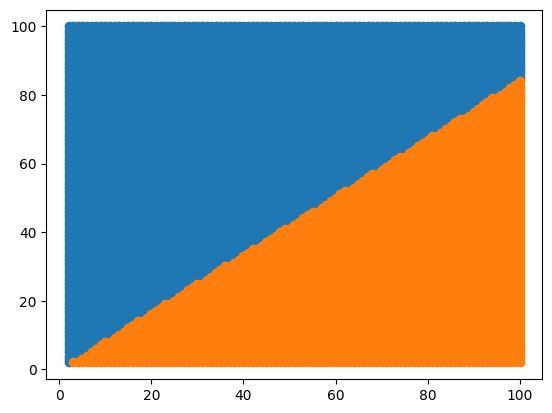

Test Accuracy: 0.9155
Guess Distribution: [1189, 811]


(0.9155, [1189, 811])

In [ ]:
k_cases = 2000
k_dbound_size = 100

dual_file = "test_data/test_simple.csv"

db2 = torch.linspace(2, k_dbound_size, k_dbound_size - 1).to(device)
two_dbs = [db2, db2]

def alt_policy(state, value_fn):
    x = [i(state) for i in k_2actions]
    x = [value_fn(i) for i in x]
    x = torch.tensor(x)
    return x

run_test(dual_file, k_2actions, policy_fn=lambda a: alt_policy(a, value_fn_2), cases=k_cases, dbs=two_dbs)
# ~99% accuracy

In [ ]:
quad_file = "test_data/four_directions_cleaner_test.csv"     # thanks, donald

k_cases = 1000

k_dbound_size = 200

db4 = torch.linspace(-k_dbound_size/2, k_dbound_size/2, k_dbound_size+1).to(device)
quad_dbs = [db4, db4]
run_test(quad_file, k_4actions, policy_fn=lambda a: torch.argmax(value_fn_4(a)), cases=k_cases)
            
# run_test(quad_file, k_4actions, policy_fn=lambda a: oh_encode(torch.tensor(determine_action(a.flatten())).view((1,1)),4), cases=k_cases, dbs=quad_dbs)
# # 8% accuracy on Donald test csv

Test Accuracy: 0.261
Guess Distribution: [1000, 0, 0, 0]


/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_8108/450618715.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(x[i]).unsqueeze(0).to(device)


In [ ]:
for i in range(0,200, 10):
    epoch = i + 1
    value_fn_4.load_state_dict(torch.load(trained_value_fp + "_" + str(epoch)))
    acc, guesses = run_test(quad_file, k_4actions, policy_fn=lambda a: alt_policy(a, value_fn_4), cases=k_cases, dbs=quad_dbs)
    print("Epoch {epoch} accuracy: " + str(acc))


SyntaxError: EOL while scanning string literal (1437133956.py, line 3)